# Lab02: Functions

**Brief Honor Code**. Do the homework on your own. You may discuss ideas with your classmates, but DO NOT copy the solutions from someone else or the Internet. If stuck, discuss with TA.

**1**. (10 points) 

Rewrite the following code into functional form using lambdas, map, filter and reduce.

In [1]:
n = 10
s = 10
for i in range(n):
    if i % 2:
        s |= i**2
s

123

In [2]:
from functools import reduce
from operator import or_

# Functional paradigm:
    # Lambdas replace explicit funtion definitons
    # Maps replace looping over arrays
    # Filters replace conditional statements
    # Reduce replaces aggregations
    
n = 10
s = 10
    
# Step 1: filter out even numbers
x = filter(lambda x: x%2, range(n))

# Step 2: square the numbers
y = map(lambda x: x**2, x)

# Step 3: reduce using condition
z = reduce(or_, y, s)
print(z)

123


**2**. (10 points)

Rewrite the code above as a `toolz` pipeline, using lambdas and curried or partially applied functions as necessary.

In [3]:
import toolz as tz
import toolz.curried as c

# Note:
    # The toolz pipeline is nice because it allows you to pipe like you would with DPLYR
    # This lets functional programs have a similar verticality to ordinary Python programs    

n = 10
s = 10

tz.pipe(
    range(n),
    c.filter(lambda x: x%2),
    c.map(lambda x: x**2),
    lambda x: reduce(or_, x, s)
)

123

**3**. (10 points) 

Repeat the Buffon's needle simulation from Lab01 as a function that takes the number of needels `n` as input and returns the estimate of $\pi$. The function should use `numpy` and vectorization.  What is $\pi$ for 1 million needles?

In [4]:
import numpy as np
import math

n = 10**6

def buffon(n):
    center = np.random.random(n)
    angle = np.random.uniform(0, np.pi, n)
    upper = center + 0.5 * np.sin(angle)
    lower = center - 0.5 * np.sin(angle)
    p = np.sum(np.where((lower<0) | (upper>1), 1, 0))/n
    return(2/p)
    
buffon(n)

3.137653568531845

**4**. (20 points) 

Simpsons rule is given by the follwoing approximation

![Simpsons](https://wikimedia.org/api/rest_v1/media/math/render/svg/a0cdf0804bb8810e4438cbea898dc7a2fedb3e57)

- Write Simpsons rule as a function `simpsons(f, a, b, n=100)` where n is the number of equally spaced intervals from `a` to `b`.  (10 points)
- Use this function to estimate the probability mass of the standard normal distribution between -1 and 1. Implement the PDF of the standard normal distribution $\psi(x)$ as a function. (10 points)

$$
\psi(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}x^2}
$$

In [5]:
# Given a function f, approximate its integral over the interval [a,b]
def simpsons(f, a, b, n=100):
    # Interval
    x = np.linspace(a, b, n+1)
    # Interval widths
    h = (b-a)/n
    
    y = 2*np.sum(f(x[2:-1:2]))
    z = 4*np.sum(f(x[1::2]))
    return (h/3)*(f(x[0]) + y + z + f(x[-1]))

In [6]:
# psi(x)
def standard_normal_pdf(x):
    return (1 / np.sqrt(2*np.pi)) * np.exp(-x**2/2)
    
simpsons(standard_normal_pdf, -1, 1)

0.6826894929975491

**5**. (50 points)

Write code to generate a plot similar to the following 

![automata](figs/automata1d.png)

using the explanation for generation of 1D Cellular Automata found [here](http://mathworld.wolfram.com/ElementaryCellularAutomaton.html). You should only need to use standard Python, `numpy` and `matplotllib`.

The input to the function making the plots should be a simple list of rules

```python
rules = [30, 54, 60, 62, 90, 94, 102, 110, 122, 126, 
         150, 158, 182, 188, 190, 220, 222, 250]
make_plots(rules, niter, ncols)
```

You may, of course, write other helper functions to keep your code modular.

- Explanation:
    - Cellular automata are a black/white (binary) grid
    - Each cell is determined by the three cells above it
        - Therefore, there are 2^3 = 8 possible configuations for cells above
        - Each configuation maps to a 1 or 0, so there are 2^8 = 256 possible decision rules
    - In this problem, have to take a decision number (integer) and map it to a binary number
    - This binary number will tell you how to graph based on the configuations above it

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, IndexLocator

In [8]:
# Convert rule number to binary format
def binary(n, width):
    assert(n<2**width)
    x = np.zeros(width)
    
    for i in range(width):
        n, m = divmod(n, 2)
        x[width-i-1] = m
        
    return x

In [9]:
# Convert rule number to rule mapping
def make_map(rule):
    bin_rule = binary(rule, 8)[::-1]
    nums = [tuple(binary(i, 3)) for i in range(8)]
    return dict(zip(nums, bin_rule))

In [10]:
# apply make_map to convert rule
# init is the configuation (0s/1s) of the top row of the graph
# niters is the height of the graph
def make_ca(rule, init, niters):
    
    # Create mapping from rule number
    mapper = make_map(rule)
    # Make grid of size 2+len(init) so that it can fully populate bottom row
    grid = np.zeros((niters, 2 + len(init)), "int")
    # Set top row of grid to init
    grid[0, 1:-1] = init
    
    for i in range(1, niters):
        # Create zip of 3 adjacent numbers in row above current iteration
        # Note: zip will make appropriate matches despite different lengths
        nums = zip(grid[i-1, 0:], grid[i-1, 1:], grid[i-1, 2:])
        # Convert zip object to new row using mapping rules
        grid[i, 1:-1] = [mapper[nums] for nums in nums]
    
    return grid[:, 1:-1]

In [11]:
def plot_grid(rule, grid, ax=None):
    if ax is None:
        ax = plt.subplot(111)
    # imshow can plot grid of arrays, see matplotlib lecture for more examples
    ax.imshow(grid, interpolation = "none", cmap = "Greys", aspect = 1, alpha = 0.8)
    ax.set_title('Rule %d' % rule)
    
    # Make graphs look like the examples
    ax.grid(True, which='major', color='grey', linewidth=0.5)
    ax.xaxis.set_major_locator(IndexLocator(1, 0))
    ax.yaxis.set_major_locator(IndexLocator(1, 0))
    ax.xaxis.set_major_formatter( NullFormatter() )
    ax.yaxis.set_major_formatter( NullFormatter() )
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

In [12]:
def make_plots(rules, niter, ncols, builder=make_ca):
    width = niter*2 + 1
    init = np.zeros(width, "int")
    init[width//2] = 1
    
    # Plot size
    nrows = (len(rules) + ncols - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize = (ncols*3, nrows*2))
    
    # Generate plots
    for i in range(nrows):
        for j in range(ncols):
            grid = builder(rules[i*ncols+j], init, niter)
            plot_grid(rules[i*ncols+j], grid, ax=axes[i,j])
    plt.tight_layout()

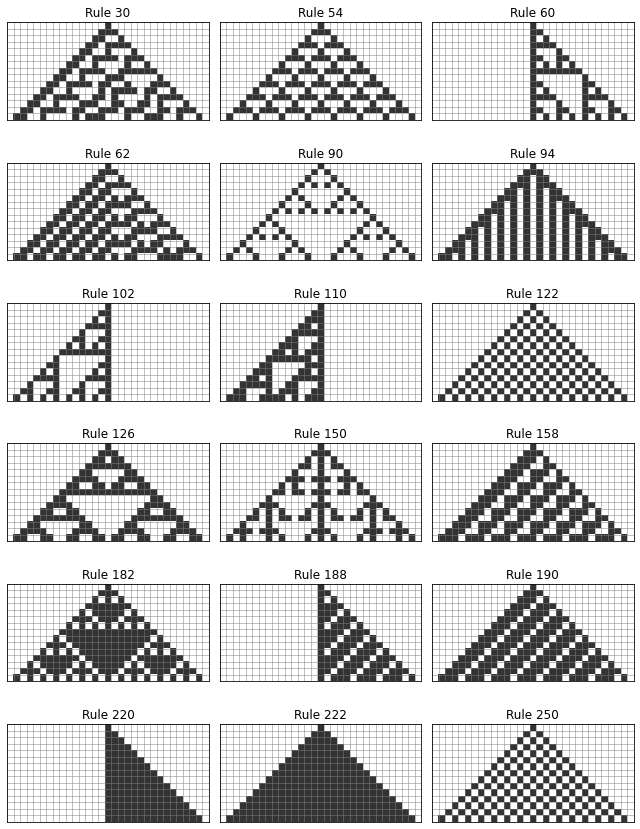

In [13]:
rules = [30, 54, 60, 62, 90, 94, 102, 110, 122, 126, 150, 158, 182, 188, 190, 220, 222, 250]
niter = 15
ncols = 3
make_plots(rules, niter, ncols)